# Scalable Synthetic Difference in Differences

This sample notebook aims to show readers how to use SynapseML's `DiffInDiffEstimator`, `SyntheticControlEstimator` and `SyntheticDiffInDiffEstimator` to estimate the causal effect of a treatment on a particular outcome.

In this sample notebook, we will use the California smoking cessation program example to demonstrate the usage. The goal of the analysis is to estimate the effect of increased cigarette taxes on smoking in California.

In [ ]:
from pyspark.sql.types import *
from synapse.ml.causal import DiffInDiffEstimator, SyntheticControlEstimator, SyntheticDiffInDiffEstimator
from matplotlib import pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np

spark.sparkContext.setLogLevel("INFO")
style.use("ggplot")

We will select 5 columns from the dataset: state, year, cigsale, california, after_treatment.

In [ ]:
df = spark.read.option("header", True).option("inferSchema", True).csv("wasbs://publicwasb@mmlspark.blob.core.windows.net/smoking.csv") \
        .select("state", "year", "cigsale", "california", "after_treatment")
display(df)

First, we use the `DiffInDiffEstimator` to estimate the causal effect with regular difference in differences method. We set the treatment indicator column to "california", set post-treatment indicator column to "after_treatment", and set the outcome column to "cigsale".

In [ ]:
estimator1 = DiffInDiffEstimator(treatmentCol="california", postTreatmentCol="after_treatment", outcomeCol = "cigsale")
model1 = estimator1.fit(df)

print("[Diff in Diff] treatment effect: {}".format(model1.treatmentEffect))
print("[Diff in Diff] standard error: {}".format(model1.standardError))

The treatment effect estimated by difference in differences should be -27.349.

Next, we use `SyntheticControlEstimator` to synthesize a control unit and use the synthetic control to estimate the causal effect. To create the synthetic control unit, we need to set the column which indicates the time when each outcome is measured, and the column which indicates the unit for which the outcome is measured.

In [ ]:
estimator2 = SyntheticControlEstimator(
    timeCol = "year", unitCol = "state", treatmentCol = "california", postTreatmentCol = "after_treatment", outcomeCol = "cigsale", 
    maxIter = 5000, numIterNoChange = 50, tol = 1E-4, stepSize = 1.0)

model2 = estimator2.fit(df)

print("[Synthetic Control] treatment effect: {}".format(model2.treatmentEffect))
print("[Synthetic Control] standard error: {}".format(model2.standardError))

The treatment effect estimated by synthetic control should be about -19.354.

Internally, a constrained least square regression is used to solve the unit weights for the synthetic control, and we can plot the loss history.

In [ ]:
lossHistory = pd.Series(np.array(model2.lossHistoryUnitWeights))

plt.plot(lossHistory[2000:])
plt.title('loss history - unit weights')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

print("Mimimal loss: {}".format(lossHistory.min()))

We can also visualize the synthetic control and compare it with the treated unit.

In [ ]:
sc_weights = model2.unitWeights.toPandas().set_index("state")
pdf = df.toPandas()
sc = pdf.query("~california").pivot(index="year", columns="state", values="cigsale").dot(sc_weights)

plt.plot(sc, label="Synthetic Control")
plt.plot(sc.index, pdf.query("california")["cigsale"], label="California", color="C1")

plt.title("Synthetic Control Estimation")
plt.ylabel("Cigarette Sales")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()

Lastly, we use `SyntheticDiffInDiffEstimator` to estimate the causal effect.

In [ ]:
estimator3 = SyntheticDiffInDiffEstimator(
    timeCol = "year", unitCol = "state", treatmentCol = "california", postTreatmentCol = "after_treatment", outcomeCol = "cigsale", 
    maxIter = 5000, numIterNoChange = 50, tol = 1E-4, stepSize = 1.0)

model3 = estimator3.fit(df)

print("[Synthetic Diff in Diff] treatment effect: {}".format(model3.treatmentEffect))
print("[Synthetic Diff in Diff] standard error: {}".format(model3.standardError))

The treatment effect estimated by synthetic control should be about -15.554.

Again, we can plot the loss history from the optimizer used to solve the unit weights and the time weights.

In [ ]:
lossHistory = pd.Series(np.array(model3.lossHistoryUnitWeights))

plt.plot(lossHistory[1000:])
plt.title('loss history - unit weights')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

print("Mimimal loss: {}".format(lossHistory.min()))

In [ ]:
lossHistory = pd.Series(np.array(model3.lossHistoryTimeWeights))

plt.plot(lossHistory[1000:])
plt.title('loss history - time weights')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

print("Mimimal loss: {}".format(lossHistory.min()))

Here we plot the synthetic diff in diff estimate together with the time weights.

In [ ]:
unit_weights = model3.unitWeights.toPandas().set_index("state")
unit_intercept = model3.unitIntercept

time_weights = model3.timeWeights.toPandas().set_index("year")
time_intercept = model3.timeIntercept

pdf = df.toPandas()
pivot_df_control = pdf.query("~california").pivot(index='year', columns='state', values='cigsale')
pivot_df_treat = pdf.query("california").pivot(index='year', columns='state', values='cigsale')
sc_did = pivot_df_control.values @ unit_weights.values
treated_mean = pivot_df_treat.mean(axis=1)

StatementMeta(jasowang33, 42, 15, Finished, Available)

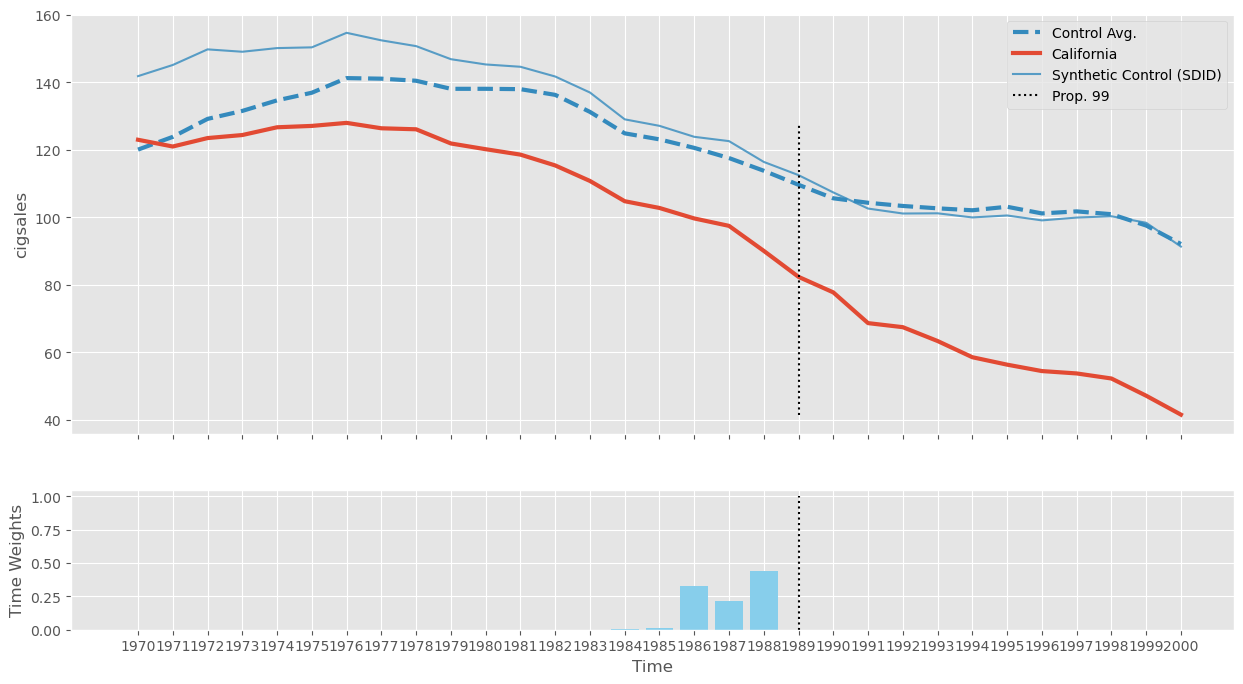

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.suptitle("Synthetic Diff in Diff Estimation")

ax1.plot(pivot_df_control.mean(axis=1), lw=3, color="C1", ls="dashed", label="Control Avg.")
ax1.plot(treated_mean, lw=3, color="C0", label="California")
ax1.plot(pivot_df_control.index, sc_did, label="Synthetic Control (SDID)", color="C1", alpha=.8)
ax1.set_ylabel("Cigarette Sales")
ax1.vlines(1989, treated_mean.min(), treated_mean.max(), color="black", ls="dotted", label="Prop. 99")
ax1.legend()

ax2.bar(time_weights.index, time_weights['value'], color='skyblue')
ax2.set_ylabel("Time Weights")
ax2.set_xlabel("Time");
ax2.vlines(1989, 0, 1, color="black", ls="dotted")